<a href="https://colab.research.google.com/github/robosquiggles/2156_Demos/blob/main/2_156_Fall_24_Demo_8_Part_2_Contrastive_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.155/6 Demo 8: Unsupervised Learning - Generative Models & Constrastive Learning - Part 2: Contrastive Learning

<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>

---

Table of Contents:

Installs and Imports
Setting up data

Part 1. Generative Models

  A: Variational Auto-Encoders (VAE)

  B: Diffusion Models

**Part 2. Contrastive Learning**

  A: Baseline Classifiers

  B: Contrastive Learning: Sim-CLR

  C: Sim-CLR Downline Classifier

### **Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from tqdm.autonotebook import tqdm, trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pandas as pd
from sklearn import preprocessing
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive
from pathlib import Path
import sklearn
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import os
from tqdm.autonotebook import tqdm

from tqdm.auto import trange, tqdm

from torch.utils.data import Dataset, DataLoader


<ipython-input-1-c5a296808f86>:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### **Helper Functions**

In [ ]:
def torch_dataset(x, y, batch_size, shuffle=True):
  x, y = torch.tensor(x), torch.tensor(y)

  data = TensorDataset(x, y)
  dataloader = DataLoader(data, batch_size=batch_size, shuffle=shuffle)

  return dataloader


def train(train_loader, model, optimizer, criterion,
          num_epochs, device):
  model = model.to(device)
  model.train()


  for epoch in range(num_epochs):
    logs = {}
    running_loss = 0.0
    prog = tqdm(enumerate(train_loader), total=len(train_loader))
    n_data = 0
    for batch_idx, (data, target) in prog:
      data, target = data.to(device), target.to(device)  # take all tensors to the same device, cpu or gpu
      optimizer.zero_grad()    # to save memory: make sure the previous gradients are not there
      output, _ = model(data)  # get predictions from the model
      loss = criterion(output, target)  # loss function
      loss.backward()  # this is the backpropagation step, everything is abstracted by PyTorch
      optimizer.step() # take one update step of the optimizer, \theta = \theta +\alpha*\nabla_J(\theta)
      running_loss += loss.detach() * data.size(0)
      n_data += data.size(0)

      prog.set_description(f"Epoch {epoch+1}/{num_epochs}")
      prog.set_postfix_str(f"Loss: {loss.item():.7f} | Running Loss: {running_loss/n_data:.7f}")

    epoch_loss = running_loss / len(train_loader)
    logs['loss'] = epoch_loss.item()

def validation(val_loader, model, device):
  model.eval()

  predictions = []
  with torch.no_grad():
    for data, target in val_loader:
      data, target = data.to(device), target.to(device)
      output, _ = model(data)
      _, pred = torch.max(output, 1)
      predictions.extend(pred.tolist())
  return predictions


def combined_validation(param_val_loader, img_val_loader, model, device):
  model.eval()

  predictions = []
  with torch.no_grad():
     for (param_data, param_target), (img_data, img_target) in zip(param_val_loader, img_val_loader):
        param_data, param_target = param_data.to(device), param_target.to(device)
        img_data, img_target = img_data.to(device), img_target.to(device)
        output = model(param_data, img_data)
        _, pred = torch.max(output, 1)
        predictions.extend(pred.tolist())
  return predictions


def eval_predictions(y_pred, class_val):
    """
    This function helps us to calculate various classification scores
    """
    scores = {}
    scores["accuracy"] = accuracy_score(class_val,y_pred)
    scores["recall"] = recall_score(class_val,y_pred, average='macro', zero_division=0)
    scores["precision"] = precision_score(class_val,y_pred, average='macro', zero_division=0)
    scores["f1_score"] = f1_score(class_val,y_pred, average='macro')

    return scores


def display_scores(scores):
  print("=============================================")
  print("||                 Scores                   ||")
  print("=============================================")
  for key, value in scores.items():
      print("||     {:<15} : {:>15.4f}    ||".format(key, value))
  print("=============================================")

## Part 2: Contrastive Leaning

In this section we will discuss contrastive learning, specifically one contrastive learning framework called Sim-CLR. As mentioned in the lectures, contrastive learning aims to maximize agreement between matching samples and minimize agreement between non matching samples. The figure below does a good job of demonstrating it:

![image](https://camo.githubusercontent.com/521fd73481dbeaefda24cd60721855083abcba70aa01c33a5bbcdf8cb0a3bf8f/68747470733a2f2f312e62702e626c6f6773706f742e636f6d2f2d2d764834504b704539596f2f586f3461324259657276492f414141414141414146704d2f766146447750584f79416f6b4143385868383532447a4f67457332324e68625877434c63424741735948512f73313630302f696d616765342e676966)

Contrastive learning is very valuable in many contexts because it can leverage unlabeled data through unsupervised learning. For example, it can train on a bunch of cat and dog images without being told which ones are cats and which ones are dogs. This gives us a platform for learning useful features and patterns in data without having labels or supervised tasks. Here we will explore a simple reduced version of SimCLR and see how it can be applied. You can take a look at the original SimCLR [paper](https://arxiv.org/abs/2002.05709) for a more in-depth look at the approach.

Before we train a SimCLR model let's first grab our dataset which is the same as part 1 and train a image-based classfier model.

In [ ]:
url = 'https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Classification/BIKED_processed.csv'
params = pd.read_csv(url, index_col=0)
url='https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Classification/Bikestyle.csv'
classes = pd.read_csv(url, index_col=0)

image_dir = 'https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/BIKED_Im/'
image_batches=[]
for i in trange(12): # We split the images into 12 files to bypass github limits.
    filename = f"images_{i}.npy"
    file_url = image_dir + filename
    !wget -q {file_url}
    image_batches.append(np.load(filename))
images = np.vstack(image_batches) # We concatenate here

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
params_scaled = min_max_scaler.fit_transform(params.values)
params_scaled = pd.DataFrame(params_scaled, columns=params.columns,index=params.index.values).astype('float32')

le = preprocessing.LabelEncoder()
le.fit(classes)
classes_num=le.transform(classes)
print(classes_num)

randomst=42
param_train, param_val, image_train, image_val, class_train, class_val = train_test_split(params_scaled, images, classes_num, test_size=0.2, random_state =randomst)
# keep the dataframe for later use in visualization
param_pd_train, param_val_pd = param_train, param_val

param_train, param_val = param_train.to_numpy(), param_val.to_numpy()
dim_params = param_train.shape[1]
image_train = np.expand_dims(image_train, axis=1).astype('float32')
image_val = np.expand_dims(image_val, axis=1).astype('float32')

dim_images=np.shape(image_train[1])
dim_classes=19

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[14  7 13 ... 14 14 14]


#### **Image Classifier**
Let's start with training a supervised CNN classifier model.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, imdims, ydims):
        super().__init__()

        self.conv1 = nn.Conv2d(imdims[0], 32, 3, stride=(2, 2))
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, stride=(2, 2))
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, stride=(2, 2))
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128*14*31, 200)
        self.bn4 = nn.BatchNorm1d(200)

        self.fc2 = nn.Linear(200, ydims)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)

        z = torch.flatten(x, 1)


        out = self.relu(self.bn4(self.fc1(z)))
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.softmax(out)

        return out, z

In [ ]:
# define hyperparameters
batch_size = 64
learn_rate = 1e-4
num_epochs = 30

# set up device: cpu or gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# create data loader for feeding into the training loop
train_loader = torch_dataset(x=image_train, y=class_train,
                             batch_size=batch_size, shuffle=True)
# create data loader for feeding into the evaluation loop
val_loader = torch_dataset(x=image_val, y=class_val,
                           batch_size=batch_size, shuffle=False)

#instantiate model, optimizer and loss/criterion
model = ConvNet(dim_images, dim_classes)
optimizer = optim.Adam(model.parameters(), lr=learn_rate)
criterion = nn.CrossEntropyLoss()

# train your model
train(train_loader, model, optimizer, criterion, num_epochs, device)

# validation loss of the trained model
y_pred = validation(val_loader, model, device)

# additional classication scores
scores = eval_predictions(y_pred,class_val)

display_scores(scores)

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

||                 Scores                   ||
||     accuracy        :          0.6800    ||
||     recall          :          0.3459    ||
||     precision       :          0.5075    ||
||     f1_score        :          0.3670    ||


#### **Unsupervised Learning**
Let's start with training an unsupervised model with a simCLR like approach.

##### **SimCLR Implementation**

SimCLR (Simple Contrastive Learning of Representations) is a framework for contrastive learning. The key ideas are:

1. First preprocess our images to make them square
2. Create batched augmentation pipeline
3. Train the model with contrastive loss
4. Evaluate using a linear probe

Processing training images...


  0%|          | 0/3609 [00:00<?, ?it/s]

Processing validation images...


  0%|          | 0/903 [00:00<?, ?it/s]

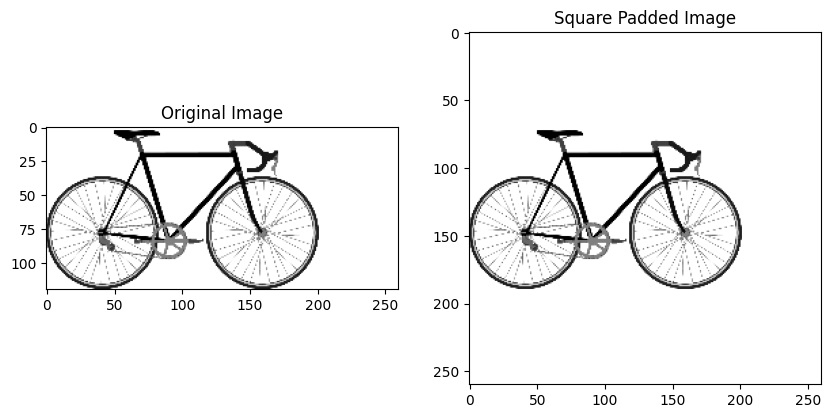

In [ ]:
# First preprocess all images to make them square
def pad_to_square(image_array, fill_value=1.0):
    """Pad single image to make it square"""
    h, w = image_array.shape
    max_size = max(h, w)

    # Calculate padding
    h_padding = (max_size - h) // 2
    w_padding = (max_size - w) // 2
    h_padding_end = max_size - h - h_padding
    w_padding_end = max_size - w - w_padding

    # Create padded image
    padded = np.pad(image_array,
                    ((h_padding, h_padding_end),
                     (w_padding, w_padding_end)),
                    mode='constant',
                    constant_values=fill_value)
    return padded

# Process all images
print("Processing training images...")
processed_train_images = np.array([pad_to_square(img[0]) for img in tqdm(image_train)])
print("Processing validation images...")
processed_val_images = np.array([pad_to_square(img[0]) for img in tqdm(image_val)])

# Add channel dimension back
processed_train_images = np.expand_dims(processed_train_images, axis=1)
processed_val_images = np.expand_dims(processed_val_images, axis=1)

# Visualize a sample
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_train[0][0], cmap='gray')
plt.title("Original Image")
# plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(processed_train_images[0][0], cmap='gray')
plt.title("Square Padded Image")
# plt.axis('off')
plt.show()

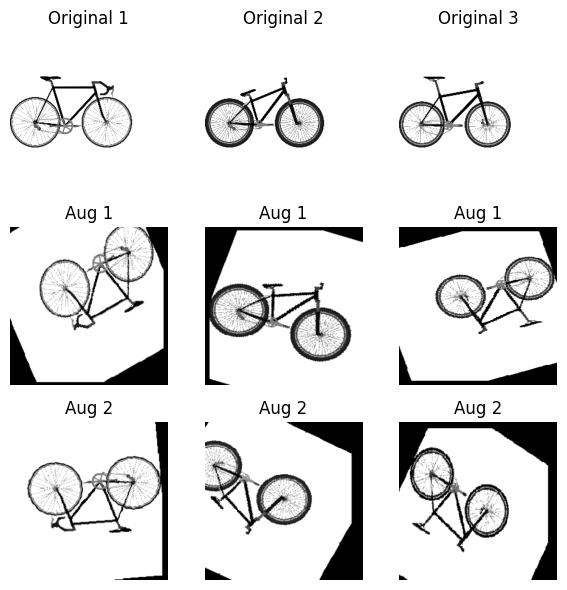

In [ ]:
import torchvision.transforms as T
from torchvision.transforms import functional as TF
from PIL import Image

class SimCLRDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = torch.FloatTensor(images)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            aug1 = self.transform(image)
            aug2 = self.transform(image)
            return aug1, aug2
        return image

# Define augmentations
simclr_transforms = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(30),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    T.RandomApply([
        T.ColorJitter(brightness=0.4,
                     contrast=0.4,
                     saturation=0.2,
                     hue=0.1)
    ], p=0.5),
    T.RandomResizedCrop(size=260, scale=(0.7,1.0))
])

# Create datasets and dataloaders
train_dataset = SimCLRDataset(processed_train_images, simclr_transforms)
train_loader = DataLoader(train_dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=2,
                         pin_memory=True)

# Visualization of augmentations
def visualize_augmentations(dataset, n_samples=3, n_augments=2):
    """Visualize multiple augmentations of several samples"""
    plt.figure(figsize=(2*n_samples, 2*(n_augments+1)))

    for i in range(n_samples):
        # Original
        image = dataset.images[i]
        plt.subplot(n_augments+1, n_samples, i+1)
        plt.imshow(image[0], cmap='gray')
        plt.title(f'Original {i+1}')
        plt.axis('off')

        # Augmentations
        for j in range(n_augments):
            aug1, aug2 = dataset[i]
            plt.subplot(n_augments+1, n_samples, (j+1)*n_samples + i+1)
            plt.imshow(aug1[0], cmap='gray')
            plt.title(f'Aug {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize augmentations
visualize_augmentations(train_dataset)

**Augmentation Examples**

The visualization above shows:
1. The original image on the top
2. Multiple randomly augmented versions of the same image
3. Each augmentation applies a random combination of:
   - Square padding to make the image square
   - Random horizontal flips
   - Random vertical flips
   - Random affine transformations
   - Random rotations (up to 30 degrees)
   - Random color/brightness/contrast adjustments
   - Random resized crop

The goal is to create different views of the same image while preserving the semantic content. These augmented pairs will be used to train the SimCLR model to learn robust representations.

##### **Contrastive Loss Function**

The NT-Xent (Normalized Temperature-scaled Cross Entropy) loss is used in SimCLR:
- Pushes representations of augmented versions of same image together
- Pushes representations of different images apart
- Temperature parameter τ controls the concentration of the distribution

In [ ]:
class SimCLRLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(SimCLRLoss, self).__init__()
        self.temperature = temperature

    def forward(self, projections1, projections2):
        # Normalize projections
        projections1 = F.normalize(projections1, dim=1)
        projections2 = F.normalize(projections2, dim=1)

        # Concatenate projections
        projections = torch.cat([projections1, projections2], dim=0)
        batch_size = projections1.shape[0]

        # Compute similarity matrix
        similarity_matrix = torch.matmul(projections, projections.T) / self.temperature

        # Mask to avoid self-comparison
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=similarity_matrix.device)
        similarity_matrix = similarity_matrix.masked_fill(mask, float('-inf'))

        # Compute positive similarities
        positive_similarities = torch.cat([
            torch.diag(similarity_matrix, batch_size),
            torch.diag(similarity_matrix, -batch_size)
        ])

        # Compute labels and loss
        labels = torch.arange(2 * batch_size, device=similarity_matrix.device)
        labels = (labels + batch_size) % (2 * batch_size)
        loss = F.cross_entropy(similarity_matrix, labels)

        return loss

# Modified ConvNet for SimCLR
class SimCLRNet(nn.Module):
    def __init__(self, imdims, projection_dim=128):
        super().__init__()

        self.conv1 = nn.Conv2d(imdims[0], 32, 3, stride=(2, 2))
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, stride=(2, 2))
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, stride=(2, 2))
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128*31*31, projection_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        # x = self.dropout(x)

        x = self.relu(self.bn2(self.conv2(x)))
        # x = self.dropout(x)

        x = self.relu(self.bn3(self.conv3(x)))
        # x = self.dropout(x)

        z = torch.flatten(x, 1)

        out = self.fc1(z)
        return z, out

##### **Training Loop**

Now we'll train the model in a self-supervised manner using contrastive learning. This process will learn useful image representations without using any labels.

In [ ]:
# Modified training function for batched augmentations
def train_simclr(model, train_loader, optimizer, criterion, device, num_epochs=10):
    model = model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        prog = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (aug1, aug2) in prog:
            # Move to device
            aug1, aug2 = aug1.to(device), aug2.to(device)

            # Get representations and projections
            _, z1 = model(aug1)
            _, z2 = model(aug2)

            # Compute loss
            loss = criterion(z1, z2)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            prog.set_description(f"Epoch {epoch+1}/{num_epochs}")
            prog.set_postfix_str(f"Loss: {loss.item():.7f} | Running Loss: {running_loss/(batch_idx+1):.7f}")

In [ ]:
# Training
batch_size = 128
learn_rate = 1e-4
num_epochs = 30

# Training
print("Starting SimCLR training...")
model = SimCLRNet(dim_images)
optimizer = optim.AdamW(model.parameters(), lr=learn_rate)
criterion = SimCLRLoss(temperature=0.1)

# Train SimCLR
train_simclr(model, train_loader, optimizer, criterion, device, num_epochs)

Starting SimCLR training...


  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Since our model is small and we augment aggressively we will need to train for quite a while, but we have less risk of overfitting because the data is always randomly augmented so the model sees different images every time!

##### **Evaluation Using Linear Probe**

To evaluate the quality of learned representations, we'll freeze the encoder and train a linear classifier on top:

In [ ]:
# Create proper datasets for linear evaluation
class LinearEvalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create evaluation dataloaders
train_eval_dataset = LinearEvalDataset(processed_train_images, class_train)
val_eval_dataset = LinearEvalDataset(processed_val_images, class_val)

train_eval_loader = DataLoader(train_eval_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=2,
                             pin_memory=True)

val_eval_loader = DataLoader(val_eval_dataset,
                           batch_size=batch_size,
                           shuffle=False,
                           num_workers=2,
                           pin_memory=True)

class LinearProbe(nn.Module):
    def __init__(self, encoder, feature_dim, num_classes):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(feature_dim, num_classes)

        # Freeze encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Get features from encoder (without projection head)
        with torch.no_grad():
            features, _ = self.encoder(x)
        # Pass through linear classifier
        return self.classifier(features)

# Extract encoder from trained SimCLR model
encoder = model

# Create and train linear probe
probe = LinearProbe(encoder, 128*31*31, dim_classes).to(device)
probe_optimizer = optim.AdamW(probe.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Modified training function for linear probe
def train_probe(train_loader, model, optimizer, criterion, device, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        prog = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (data, target) in prog:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            prog.set_description(f"Epoch {epoch+1}/{num_epochs}")
            prog.set_postfix_str(
                f"Loss: {loss.item():.4f} | "
                f"Acc: {100.*correct/total:.2f}% | "
                f"Running Loss: {running_loss/(batch_idx+1):.4f}"
            )

# Validation function for linear probe
def validate_probe(val_loader, model, device):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            output = model(data)
            _, pred = output.max(1)
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.numpy())

    return np.array(predictions), np.array(targets)

print("Training linear probe...")
train_probe(train_eval_loader, probe, probe_optimizer, criterion, device, num_epochs=30)

print("\nEvaluating...")
y_pred, y_true = validate_probe(val_eval_loader, probe, device)
scores = eval_predictions(y_pred, y_true)
display_scores(scores)

Training linear probe...


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]


Evaluating...
||                 Scores                   ||
||     accuracy        :          0.7143    ||
||     recall          :          0.3967    ||
||     precision       :          0.5540    ||
||     f1_score        :          0.4268    ||


Not bad given we are only training a single linear layer at this point and still out-perfomed the fully supervised model!

 You can see how a pretrained contrastive model which is trained on data in an unsupervised way can be utilized so effectively for downline tasks with minimal training on top of the models predictions. Here we never gave the larger CNN any information about classification labels. Rather, we just trained in an unsupervised fashion and later just used the models predicted features to train a small single layer classifer. This is a really nice feature of contrastive learning.

#### **Part 2 Reflection Questions**
1. We see that contrastive model can learn just from unlabeld and general data in an usupervised manner. Other than perfoming downline regression/classification, can you think of a few other ways you could use a pretrained contrastive learning model?
2. In constrastive learning we don't have to use the same data on each side of the contrastive loss. Describe how you would use contrastive models if you have a dataset with multiple modalities of data (just like here were we have tabular and image data)?

---
---
***Optional Questions:***

3. Can you come up with a couple of ways to bring contrastive learning and generative models together? Can you think of a few applications of doing such a thing in engineering design tasks?
4. What can you say about the dynamics of contrastive learning and synthetic unlabeled data? When generating or gathering synthetic data we may not be able to label all of them but they include very useful information. describe how you would use contrastive learning to improve deep learning models in an unsupervised way with contrastive learning.